# Image Classification with CNNs

This notebook has been created via AWS, launching a custom fastai AMI with the fastai libraries and environment pre-set.

We'll use an example to illustrate the classification of images using neural networks, in particular, classifying of images of Cats & Dogs.

**Intialisation of notebook:**

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
sz = 224

## Deep Learning - Key Elements

In short Deep Learning uses a pre-defined Neural Network structure along with Gradient Descent to optimise a loss function.

### 1. Neural Networks

There are two main types of neural networks:
1. Convolutional Neural Networks (used for images)
2. Recurrent Neural Networks (used for text)

Visual representation:  
![Image of NeuralNet](https://www.analyticsvidhya.com/wp-content/uploads/2016/03/2.-ann-structure.jpg)

At each layer of the neural network, each node has a set of nodes from the previous layer that feed into it. At each node we apply a linear transformation from the values of these features and apply an activation function (e.g. ReLU - Rectified Linear Unit).  

We randomise the initial distribution of all these constants, and then apply Gradient Descent to our final loss function in order to improve the parameter estimates.

Note that at each stage we need our activation function, else our functions will simply collapse into one bigger linear function.

### 2. Gradient Descent:

![Image of GD](http://blog.datumbox.com/wp-content/uploads/2013/10/gradient-descent.png)

![Image of GD2](http://forums.fast.ai/uploads/default/original/2X/c/c4318c45347f4ec645aa01c4f435051147b0f37c.gif)

## EDA:

**Obtaining the data:**

We obtain the data using the following command line code:  
`wget http://files.fast.ai/data/dogscats.zip`

In [2]:
PATH = "data/dogscats/"

In [5]:
files = !ls {PATH}valid/cats | head

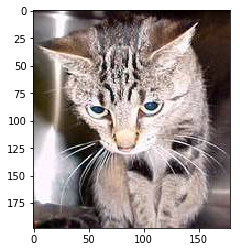

In [6]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

In [7]:
img.shape

(198, 179, 3)

In [8]:
img[:4,:4]

array([[[ 29,  20,  23],
        [ 31,  22,  25],
        [ 34,  25,  28],
        [ 37,  28,  31]],

       [[ 60,  51,  54],
        [ 58,  49,  52],
        [ 56,  47,  50],
        [ 55,  46,  49]],

       [[ 93,  84,  87],
        [ 89,  80,  83],
        [ 85,  76,  79],
        [ 81,  72,  75]],

       [[104,  95,  98],
        [103,  94,  97],
        [102,  93,  96],
        [102,  93,  96]]], dtype=uint8)

## Analysing Pre-Trained Model:

To start with, instead of building our own model, we'll use the **resnet34** model - pre-trained on ImageNet data.

In [9]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(resnet34, sz))
learn = ConvLearner.pretrained(resnet34, data, precompute=True)

100%|██████████| 32/32 [00:11<00:00,  2.73it/s]


In [10]:
learn.fit(0.01, 1) # Note: 0.01 represents the learning rate, 1 is the number of epochs

A Jupyter Widget

[ 0.       0.04365  0.02317  0.99219]                          



Let's explore some of the predictions our model is making:

In [11]:
data.val_y # Label for validation set data

array([0, 0, 0, ..., 1, 1, 1])

In [17]:
len(data.val_y) # 2000 observations in validation set

2000

In [12]:
data.classes # Cats -> 0, Dogs -> 1

['cats', 'dogs']

In [16]:
log_preds = learn.predict() # Model stores predictions on a log scale

In [19]:
log_preds.shape

(2000, 2)

In [22]:
log_preds[:4,:] # Two columns represent probs of cat/dog

array([[ -0.00003, -10.34337],
       [ -0.0031 ,  -5.77885],
       [ -0.00009,  -9.33326],
       [ -0.00749,  -4.89761]], dtype=float32)

Turn this array of logarithmic predictions into probabilities and concrete predictions:

In [24]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1, pick the highest probability
prob_dog = np.exp(log_preds[:,1])        # pr(dog)
prob_cat = np.exp(log_preds[:,0])     # pr(cat)

In [25]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [28]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [prob_dog[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

Correctly classified


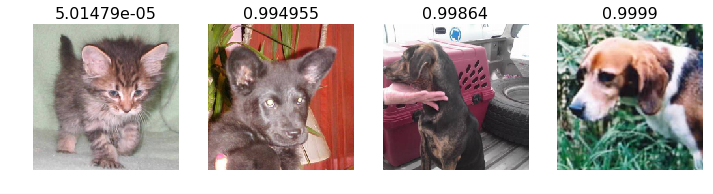

In [29]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


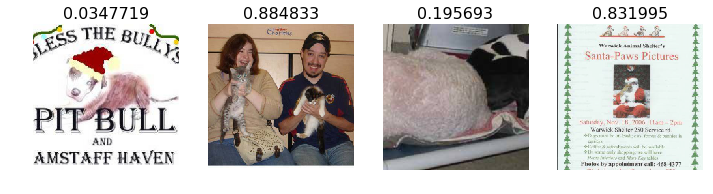

In [30]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [33]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * prob_dog[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most correct cats


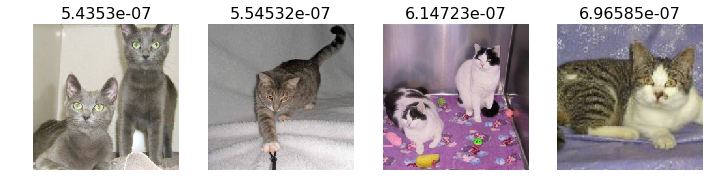

In [34]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


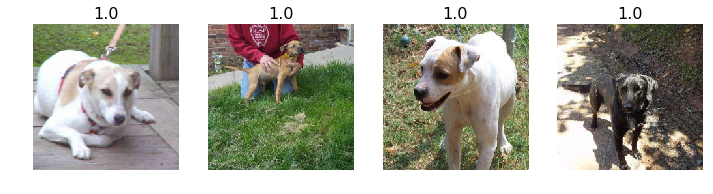

In [35]:
plot_val_with_title(most_by_correct(1,True),"Most correct dogs")

Most incorrect cats


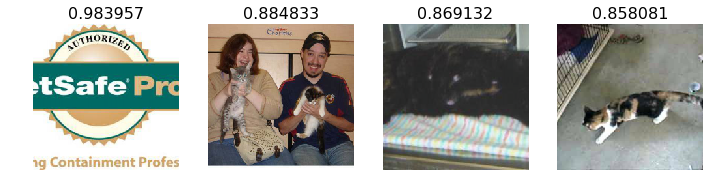

In [36]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


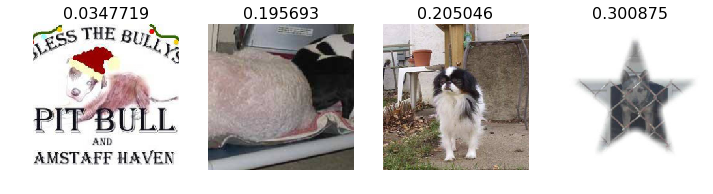

In [37]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


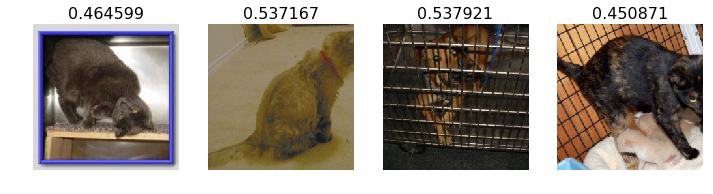

In [39]:
most_uncertain = np.argsort(np.abs(prob_dog -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

### Learning Rates:

*Learning Rate* is the first hyper-parameter we will consider, this correspond to the rate which we will change our estimates while performing gradient descent.

In [43]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True)

In [44]:
lrf=learn.lr_find()

A Jupyter Widget

 83%|████████▎ | 300/360 [00:02<00:00, 141.17it/s, loss=0.473]


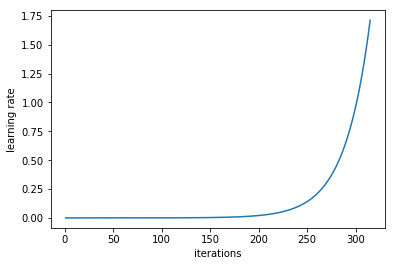

In [45]:
learn.sched.plot_lr()

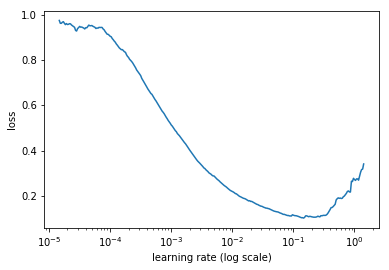

In [46]:
learn.sched.plot()

So we see an optimum learning rate at approximately 0.1.